In [2]:
import torchvision.datasets as datasets
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
def prep_mnist(mnist_set, n_components):
    # should we normalize the data?
    filtered_mnist_set = []
    for image in mnist_set:
        if image[1] == 0 or image[1] == 1:
            filtered_mnist_set.append(image)

    X = [np.asarray(val[0]).flatten() for val in filtered_mnist_set]
    Y = [val[1] for val in filtered_mnist_set]

    pca = PCA(n_components=n_components)
    X_PC = pca.fit_transform(X)
    return (X_PC, Y)

In [4]:
class KNNClassifier:
    def __init__(self, X, Y):
        self.X_clf = X
        self.Y_clf = Y

    def classify(self, x, k, dist_func=np.linalg.norm):
        # Implement the k-NN classifier
        # x is a single vector to classify
        # k is the number of neighbors to consider
        # returns the most common class among the k nearest neighbors
        if self.X_clf is None or self.Y_clf is None:
            raise Exception("Classifier not trained")
        dist = []
        for i in range(len(self.X_clf)):
            dist.append((dist_func(self.X_clf[i] - x), self.Y_clf[i]))
        # look at the k nearest neighbors
        dist.sort(key=lambda tup: tup[0])
        dist = dist[:k]
        # count the number of 0s and 1s
        count0 = 0
        count1 = 0
        for i in range(len(dist)):
            if dist[i][1] == 0:
                count0 += 1
            else:
                count1 += 1
        # return the most common class
        if count0 > count1:
            return 0
        else:
            return 1

1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1


ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

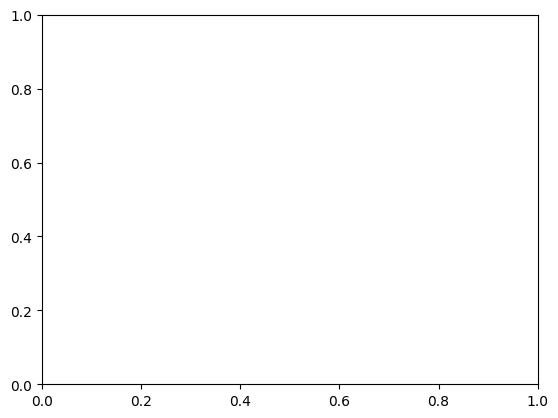

In [6]:
K_VALUES = [1, 2, 3, 4, 5]
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

X_PC, Y = prep_mnist(mnist_trainset, 2)
X_test_PC, Y_test = prep_mnist(mnist_testset, 2)

knn = KNNClassifier(X_PC, Y)
preds_results = {}
for k_val in K_VALUES:
    preds_results[k_val] = []
    for i in range(len(X_test_PC)):
        pred = knn.classify(X_test_PC[i], k_val)
        if i % 100 == 0:
            print(pred, Y_test[i])
        preds_results[k_val].append((pred, Y_test[i]))


In [14]:
for k_val in preds_results:
    correct = 0
    for pred in preds_results[k_val]:
        if pred[0] == pred[1]:
            correct += 1
    print(f"KNN with k:{k_val} is {correct/len(preds_results[k_val])}")
    

KNN with k:1 is 0.9962174940898345
KNN with k:2 is 0.9947990543735225
KNN with k:3 is 0.9981087470449173
KNN with k:4 is 0.9971631205673759
KNN with k:5 is 0.9985815602836879


(12665, 2)